In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from scipy.ndimage import gaussian_filter1d

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

sigma = 2

#this can run all of the pairs in ~ 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]


# classes_left = np.arange(0, 20)
# classes_right = np.arange(0, 20)

classes_left = [12]
classes_right = [18]

#classes_left = [19]
#classes_right = [19]

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]

    # Extract LFP signals
    left_input_SP = data['SP'][0][0]
    right_input_SP = data['SP'][0][1]
    attention_SP = data['SP'][0][2]

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1:
                left_input_attendingleft_t = left_input_SP[left_indices, 100:350, :]
                right_input_attendingleft_t = right_input_SP[left_indices, 100:350, :]
                attention_layer_attendingleft_t = attention_SP[left_indices, 100:350, :]

                num_trials_left, num_samples, num_neurons_left = left_input_attendingleft_t.shape
                num_neurons_attention = 80

                left_in_attleft_sm = smooth_with_gaussian(left_input_attendingleft_t, sigma=sigma) 
                right_in_attleft_sm = smooth_with_gaussian(right_input_attendingleft_t, sigma=sigma) 
                attlay_attleft_sm = smooth_with_gaussian(attention_layer_attendingleft_t, sigma=sigma) 


                for j in range(0, num_trials_left):
                    for i in range(0, num_neurons_left):
                        count_left = np.count_nonzero(left_input_attendingleft_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attleft_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingleft_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attleft_sm[j, :, i] /= count_right


                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingleft_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attleft_sm[j, :, i] /= count_attention

                left_in_attleft_sum = np.sum(left_in_attleft_sm, axis=2)
                right_in_attleft_sum = np.sum(right_in_attleft_sm, axis=2)
                attlay_attleft_sum = np.sum(attlay_attleft_sm, axis=2)

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attleft_sum)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attleft_sum)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attleft_sum)

            if len(right_indices) >= 1:
                left_input_attendingright_t = left_input_SP[right_indices, 100:350, :]
                right_input_attendingright_t = right_input_SP[right_indices, 100:350, :]
                attention_layer_attendingright_t = attention_SP[right_indices, 100:350, :]



                left_in_attright_sm = smooth_with_gaussian(left_input_attendingright_t, sigma=sigma) 
                right_in_attright_sm = smooth_with_gaussian(right_input_attendingright_t, sigma=sigma)
                attlay_attright_sm = smooth_with_gaussian(attention_layer_attendingright_t, sigma=sigma)


                num_trials_right, num_samples, num_neurons_right = left_input_attendingright_t.shape

                num_neurons_attention = 80


                for j in range(0, num_trials_right):
                    for i in range(0, num_neurons_right):
                        count_left = np.count_nonzero(left_input_attendingright_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attright_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingright_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attright_sm[j, :, i] /= count_right    

                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingright_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attright_sm[j, :, i] /= count_attention


                left_in_attright_sum = np.sum(left_in_attright_sm, axis=2)
                right_in_attright_sum = np.sum(right_in_attright_sm, axis=2)
                attlay_attright_sum = np.sum(attlay_attright_sm, axis=2)

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attright_sum)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attright_sum)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attright_sum)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")

for file_number in file_numbers:
    if left_input_LFP_attleft_agg[f'dataset_{file_number}']['left_class_12']['right_class_18']:
        print(f"Dataset {file_number} has {len(left_input_LFP_attleft_agg[f'dataset_{file_number}']['left_class_12']['right_class_18'][0])} trials for left attleft")

for file_number in file_numbers:
    if left_input_LFP_attright_agg[f'dataset_{file_number}']['left_class_12']['right_class_18']:
        print(f"Dataset {file_number} has {len(left_input_LFP_attright_agg[f'dataset_{file_number}']['left_class_12']['right_class_18'][0])} trials for left attright")

for file_number in file_numbers:
    print(f'n_values left for dataset {file_number} = {n_values[f"dataset_{file_number}"]["left_class_12"]["right_class_18"]["attleft"]}')

for file_number in file_numbers:    
    print(f'n_values right for dataset {file_number} = {n_values[f"dataset_{file_number}"]["left_class_12"]["right_class_18"]["attright"]}')


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 45.50 seconds
Dataset 1 processed in 2.03 seconds
Dataset 2 loaded in 23.31 seconds
Dataset 2 processed in 1.46 seconds
Dataset 4 loaded in 24.91 seconds
Dataset 4 processed in 1.43 seconds
Dataset 8 loaded in 25.82 seconds
Dataset 8 processed in 2.43 seconds
Dataset 14 loaded in 51.97 seconds
Dataset 14 processed in 4.89 seconds
Dataset 15 loaded in 48.69 seconds
Dataset 15 processed in 2.74 seconds
Dataset 20 loaded in 32.07 seconds
Dataset 20 processed in 2.33 seconds
Dataset 23 loaded in 25.51 seconds
Dataset 23 processed in 1.33 seconds
Dataset 1 has 2 trials for left attleft
Dataset 2 has 1 trials for left attleft
Dataset 4 has 1 trials for left attleft
Dataset 14 has 1 trials for left attleft
Dataset 15 has 3 trials for left attleft
Dataset 20 has 2 trials for left attleft
Dataset 23 has 2 trials for left attleft
Dataset 2 has 1 trials for left attright
Dataset 4 has 2 trials for left attright
Dataset 8 has 2 trials for left attright
Dataset 14 has 1 trials f

In [2]:

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_LFP_attleft_all = copy.deepcopy(all_structure)
right_input_LFP_attleft_all = copy.deepcopy(all_structure)
attention_LFP_attleft_all = copy.deepcopy(all_structure)

left_input_LFP_attright_all = copy.deepcopy(all_structure)
right_input_LFP_attright_all = copy.deepcopy(all_structure)
attention_LFP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
print('full left attleft', left_input_LFP_attleft_all["left_class_12"]["right_class_18"])
print('full left attright',left_input_LFP_attright_all["left_class_12"]["right_class_18"])

for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('full left attleft', left_input_LFP_attleft_all["left_class_12"]["right_class_18"], 'with length', len(left_input_LFP_attleft_all["left_class_12"]["right_class_18"]))
print('full left attright',left_input_LFP_attright_all["left_class_12"]["right_class_18"], 'with length', len(left_input_LFP_attright_all["left_class_12"]["right_class_18"]))

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)


n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )

#this should now pick a class pair, and just sum the number in the dataset for each attention condition

print('total number of trials in left attleft =', n_values_sum['left_class_12']['right_class_18']['attleft'])
print('total number of trials in left attright =', n_values_sum['left_class_12']['right_class_18']['attright'])


for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = (attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])  



full left attleft [array([[1.18076696e+00, 1.34847759e+00, 1.62192173e+00, ...,
        1.24271812e-04, 2.95176094e-05, 6.16332337e-06],
       [5.10979491e-03, 5.26237898e-03, 5.56870516e-03, ...,
        7.39978712e-02, 7.67877129e-02, 7.93154488e-02]]), array([[0.06591548, 0.07544851, 0.0959577 , ..., 0.0085522 , 0.01055137,
        0.01213583]]), array([[2.87320388, 2.82123303, 2.71714388, ..., 0.01167136, 0.01145437,
        0.01110076]]), array([[0.61050926, 0.74618826, 0.98551237, ..., 0.02530971, 0.02713929,
        0.02698352]]), array([[0.10193956, 0.09972396, 0.0975808 , ..., 0.00757535, 0.00787865,
        0.00766987],
       [0.11242775, 0.1118183 , 0.11184313, ..., 0.01468574, 0.01094913,
        0.00820244],
       [0.14786595, 0.15932777, 0.18106503, ..., 0.00224104, 0.00321926,
        0.00398037]]), array([[0.02754411, 0.02469934, 0.02183351, ..., 0.01615776, 0.01148762,
        0.00797624],
       [1.95034723, 1.87599185, 1.74137582, ..., 0.00378709, 0.00369149,
    

raw_data_left shape = (36, 250)
raw data left reshaped = (3, 3000)
raw_data_left = <RawArray | 3 x 3000 (6.0 s), ~78 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]
 [2750    0    1]]


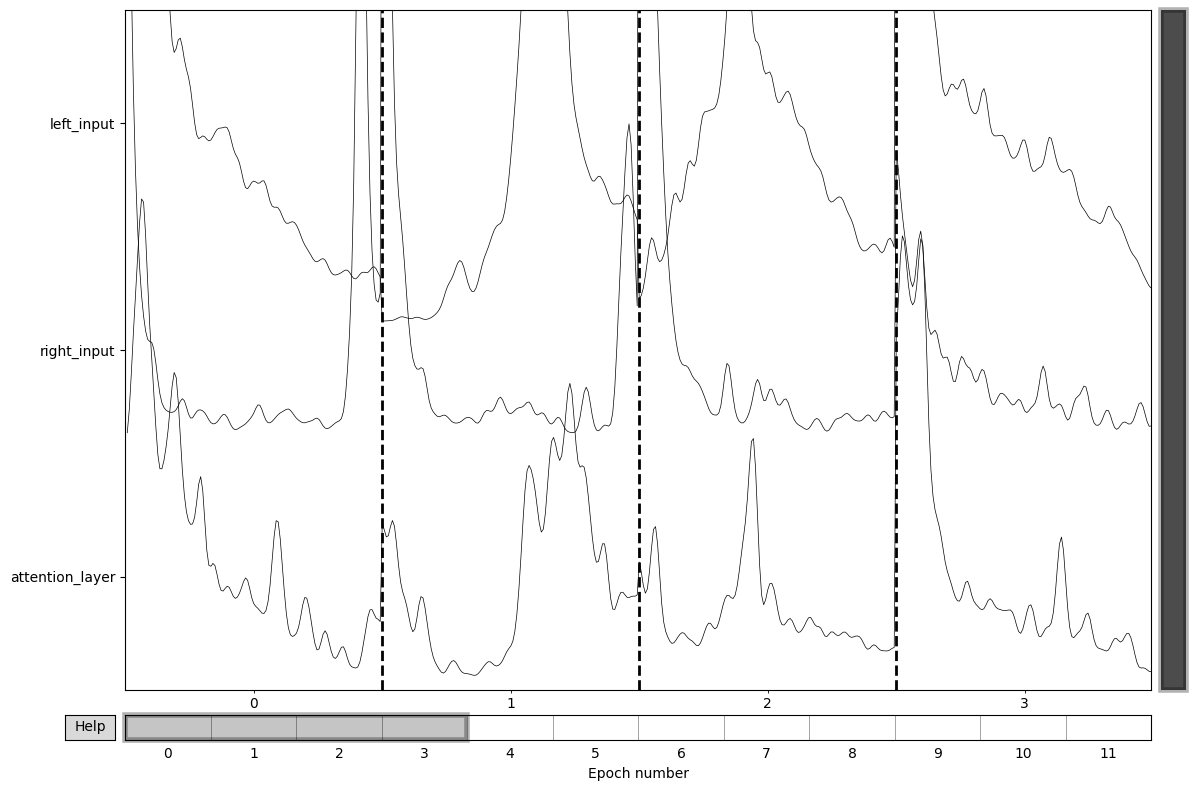

[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]]


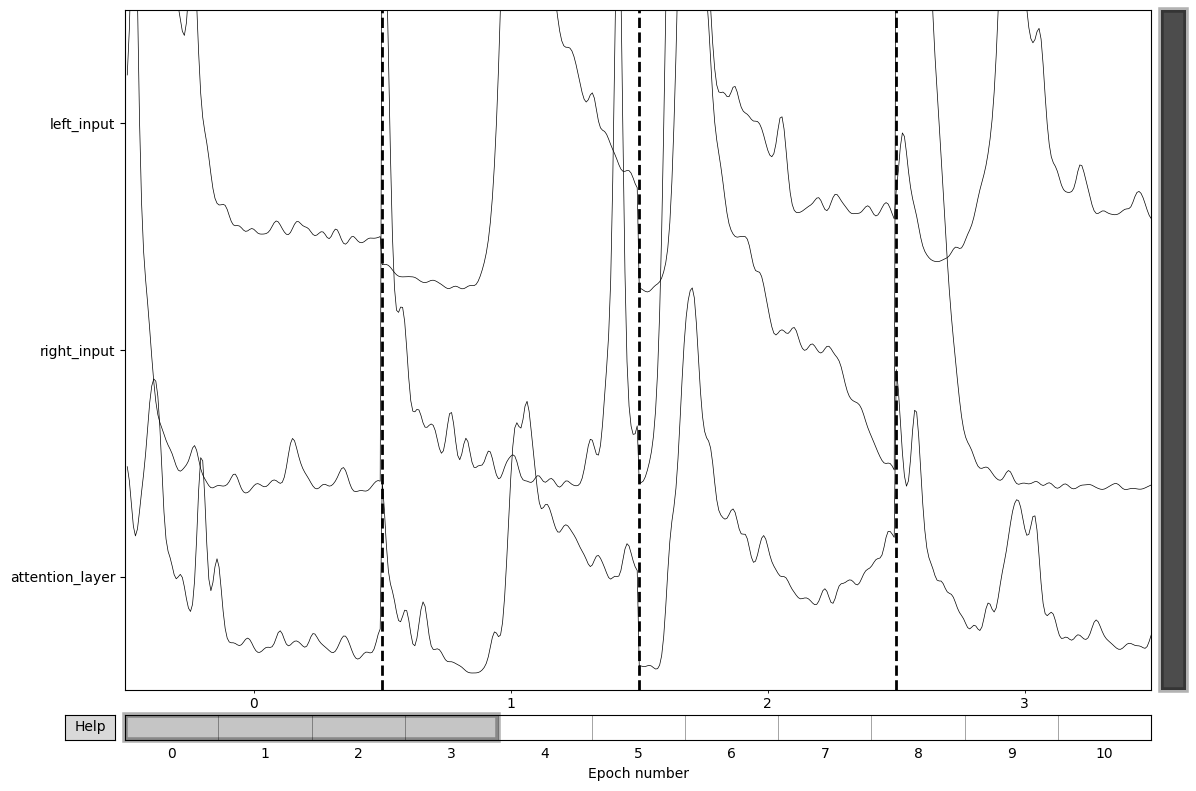

raw_data_left shape = (36, 250)
raw data left reshaped = (3, 3000)
raw_data_left = <RawArray | 3 x 3000 (6.0 s), ~78 kB, data loaded>
[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]
 [2750    0    1]]


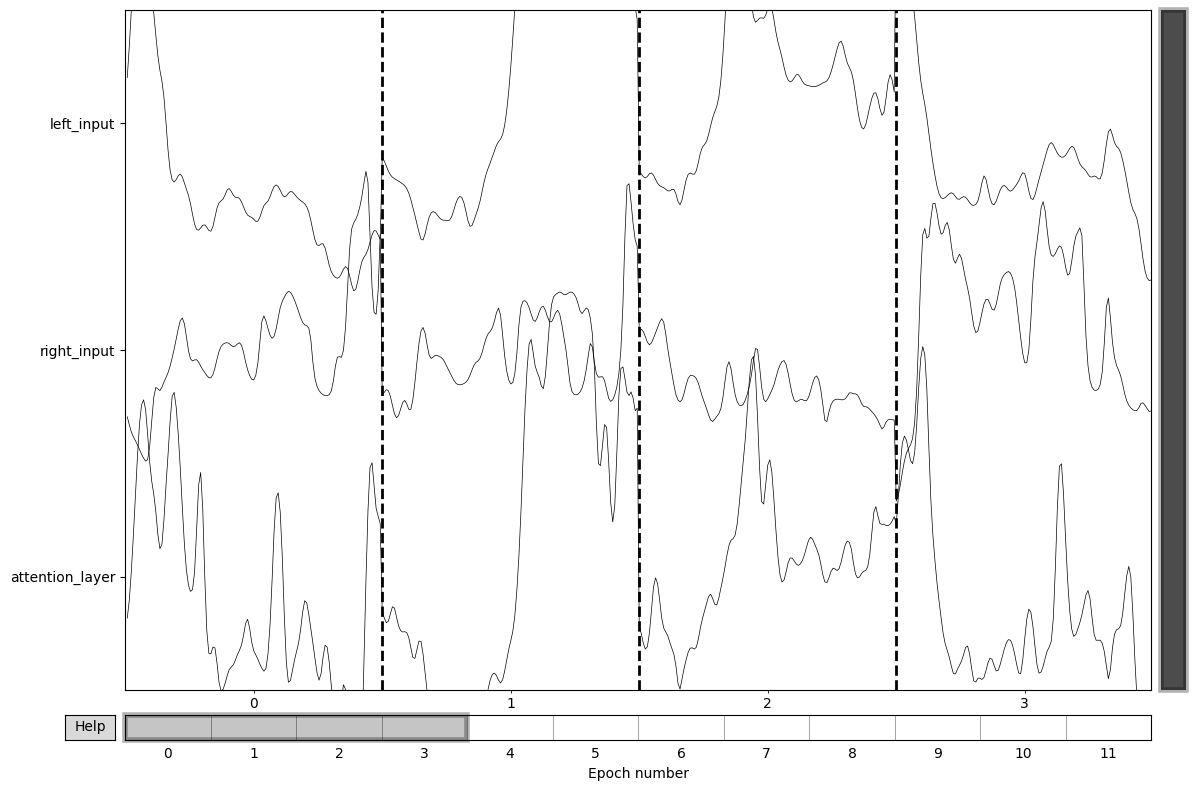

[[   0    0    1]
 [ 250    0    1]
 [ 500    0    1]
 [ 750    0    1]
 [1000    0    1]
 [1250    0    1]
 [1500    0    1]
 [1750    0    1]
 [2000    0    1]
 [2250    0    1]
 [2500    0    1]]


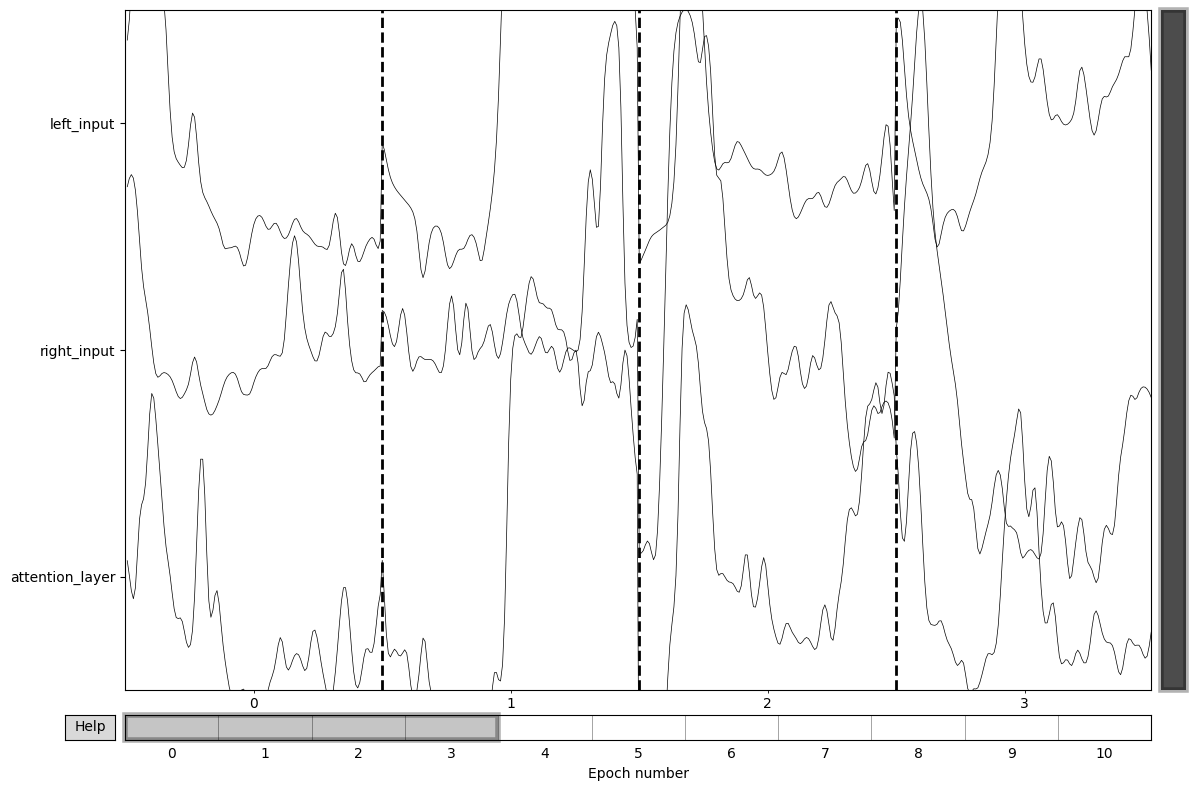

In [3]:

#-------------wsmi calculation----------------
n_times = 250
dt = 0.002
sfreq = 1 / dt

ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

wsmi_means = {}
wsmi_stdevs = {}


for class_left in classes_left:
    wsmi_start = time.time()
    wsmi_means[f'left_class_{class_left}'] = {}
    wsmi_stdevs[f'left_class_{class_left}'] = {}


    for class_right in classes_right: 
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:
            continue            


        wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }
        wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }

        #--can store the mean for each condition and each pair
        
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        print("raw_data_left =", raw_left)



        #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        events_left = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        print(events_left)

        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.25,  baseline=None, preload=True)

        epochs_left.plot(n_epochs = 4, n_channels=3, scalings = 'auto', title="Attention Left")
        plt.show()



for class_left in classes_left:
    wsmi_start = time.time()
    wsmi_means[f'left_class_{class_left}'] = {}
    wsmi_stdevs[f'left_class_{class_left}'] = {}


    for class_right in classes_right:       
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  
            continue      


        wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }
        wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }

        #--can store the mean for each condition and each pair
        
        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}']            
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        print(events_right)

        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.25, baseline=None, preload=True)
        
        epochs_right.plot(n_epochs = 4, n_channels=3, scalings = 'auto', title="Attention Right")
        plt.show()
        



def preprocess_data(data):
    # data = detrend(data, axis = 0)   #data seems to look nicer if i do this

    for i in range(len(data)):
        data[i] = detrend(data[i])

    data = zscore(data, axis = 0)
    return data

for class_left in classes_left:
    for class_right in classes_right:
        left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

        left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
        att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = preprocess_data(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])  




#------------plotting again post processing-----------------------
wsmi_means = {}
wsmi_stdevs = {}


for class_left in classes_left:
    wsmi_start = time.time()
    wsmi_means[f'left_class_{class_left}'] = {}
    wsmi_stdevs[f'left_class_{class_left}'] = {}


    for class_right in classes_right: 
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:
            continue            


        wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }
        wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }

        #--can store the mean for each condition and each pair
        
        #reshaping data for attention left
        raw_data_left = np.concatenate([
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], 
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] 
            ], axis=0)

        print("raw_data_left shape =", raw_data_left.shape)  
        #Reshape into (n_channels, n_samples)
        raw_data_left = raw_data_left.reshape(3, -1)  
        print('raw data left reshaped =', raw_data_left.shape) 
        raw_left = mne.io.RawArray(raw_data_left, info)
        print("raw_data_left =", raw_left)



        #defininf event objects, arrays like [0,0,1], [500, 0, 1], [1000, 0, 1] etc
        events_left = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft']) ])
        print(events_left)

        epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.25,  baseline=None, preload=True)

        epochs_left.plot(n_epochs = 4, n_channels=3, scalings = 'auto', title="Attention Left")
        plt.show()



for class_left in classes_left:
    wsmi_start = time.time()
    wsmi_means[f'left_class_{class_left}'] = {}
    wsmi_stdevs[f'left_class_{class_left}'] = {}


    for class_right in classes_right:       
        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  
            continue      


        wsmi_means[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }
        wsmi_stdevs[f'left_class_{class_left}'][f'right_class_{class_right}'] = {
            'left_attleft': [],
            'right_attleft': [],
            'left_attright': [],
            'right_attright': []
        }

        #--can store the mean for each condition and each pair
        
        #reshaping date for attention right 
        raw_data_right = np.concatenate([
            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'],
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}']            
        ], axis=0)

        #print('raw_data_right shape =', raw_data_right.shape)
        raw_data_right = raw_data_right.reshape(3, -1)
        #print('raw_data_right reshaped =', raw_data_right.shape)
        raw_right = mne.io.RawArray(raw_data_right, info)
        #print('raw_data_right =', raw_right)


        events_right = np.array([[i * n_times, 0, 1] for i in range(0, n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright']) ]) 
        print(events_right)

        epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.25, baseline=None, preload=True)
        
        epochs_right.plot(n_epochs = 4 , n_channels=3, scalings = 'auto', title="Attention Right")
        plt.show()
        